# PyMC Dimensionality
PyMC provides a number of ways to specify the dimensionality of its distributions. In this document we will not provide an exhaustive explanation but rather an overview and current best practices. 

## Glossary
In this document we'll be using the term dimensionality to refer to the idea of dimensions. Each of the terms below has a specific
semantic and computational definition in PyMC.  While we share them here they will make much more sense when viewed in the examples below.

+ *Implied dimensions* → dimensionality that follows from inputs to the RV
+ *Support dimensions* → dimensions you can NEVER get rid of
+ *`ndim_support`* → smallest shape that can result from a random draw. This is a fixed attribute in the distribution definition
+ *Shape* → final resulting tensor shape
+ *Size* → shape minus the support dimensions
+ *Dims* → An array of dimension names
+ *Coords* → A named array that can be used to specify dimensionality


## General Recommendations
### When prototyping implied and size are convenient
Implied dimensions are easy to specify and great for quickly expanding an existing RV. F

### For reusable code we suggest dims
For any more important work, or reuable work we suggest dims and coords as the labels will be passed to {class}'arviz.InferenceData'. This is both best practice transparency and readability for others. It also is useful in single developer workflows, for example, in cases where there is a 3 dimensional or higher RV it'll help indiciate which dimension corresponds to which model concept.

### Use shape if you'd like to be explicit
Use shape if you'd like to bypass any dimensionality calculations implicit in PyMC. This will strictly specify the dimensionality to Aesara

### When debugging use unique prime numbers
By using prime numbers it will be easier to determine where how input dimensionalities are being converted to output dimensionalities.
Once confident with result then change the dimensionalities to match your data or modeling needs.

## Code Examples

In [1]:
import pymc as pm
import numpy as np

## Scalar distribution example
We can start with the simplest case, a single Normal distribution. We specify one as shown below

In [2]:
normal_dist = pm.Normal.dist()

We can then take a random sample from that same distribution and print both the draw and shape

In [3]:
random_sample = normal_dist.eval()
random_sample, random_sample.shape

(array(-1.11530499), ())

In this case we end up with a single scalar value. This is consistent with the distributions `ndim_supp` as the smallest random draw dimension is a scalar which has a dimension of zero

In [4]:
pm.Normal.rv_op.ndim_supp

0

### Implied Example

If we wanted three draws from differently centered Normals we instead could pass a vector to the parameters. When generating a random draw we would now expect a vector value, in this case a vector if size 3. This is a case of *implied dimensions*

In [5]:
random_sample = pm.Normal.dist(mu=[1,10,100], sd=.0001).eval()
random_sample, random_sample.shape

(array([ 1.00002897,  9.9999175 , 99.99994224]), (3,))

### Shape and Size

Alternatively we may just want three draws from identical distributions. In this case we could use either `shape` or `size` to specify this

In [6]:
random_sample = pm.Normal.dist(size=(3,)).eval()
random_sample, random_sample.shape

(array([-0.56435014,  0.28613655, -0.92945242]), (3,))

In [7]:
random_sample = pm.Normal.dist(shape=(3,)).eval()
random_sample, random_sample.shape

(array([ 0.23463317, -0.24455629, -2.23058663]), (3,))

### Inspecting dimensionality with a model graph
A powerful tool to understand and debug dimensionality in PyMC is the `pm.model_to_graphviz` functionality. Rather than inspecting array outputs we instead can read the Graphviz output to understand the dimensionality.

In the example below the number on the bottom left of each box indicates the dimensionality of the Random Variable. With the scalar distribution it is implied to be one random draw of `ndim_support`

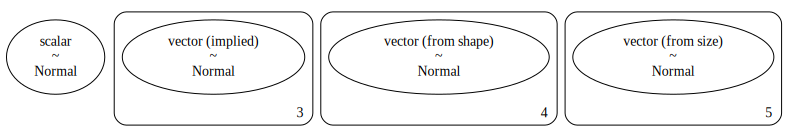

In [8]:
with pm.Model() as pmodel:
    pm.Normal("scalar") # shape=()
    pm.Normal("vector (implied)", mu=[1,2,3])
    pm.Normal("vector (from shape)", shape=(4,))
    pm.Normal("vector (from size)", size=(5,))
    
pm.model_to_graphviz(pmodel)

## Dims
A new feature of PyMC is `dims` support. With many random variables it can become confusing which dimensionality corresponds to which "real world" idea, e.g. number of observations, number of treated units etc. The dims argument is an additional label to help.

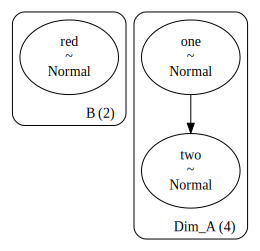

In [9]:
with pm.Model() as pmodel:
    pm.Normal("red", size=2, dims="B")

    pm.Normal("one", [1,2,3,4], dims="Dim_A")  # (4,)
    pm.Normal("two", dims="Dim_A")


pm.model_to_graphviz(pmodel)

Where dims can become increasingly powerful is with the use of `coords` specified in the model itself. With this it becomes easy to track. As an added bonus the coords and dims will also be present in the returned {class}'arviz.InferenceData' simplifying the entire workflow.

In [10]:
with pm.Model(coords={
    "year": [2020, 2021, 2022],
}) as pmodel:
    
    pm.Normal("Normal_RV", dims="year")

    pm.model_to_graphviz(pmodel)

## Vector Distributions
Some distributions by definition cannot return scalar values as random samples, but instead will return an array as their result. An example is the Multivariate Normal. The simplest possible return shape can be verified using `ndim_supp`. The value here indicates the smallest shape that can be returned is a vector

In [11]:
pm.MvNormal.rv_op.ndim_supp

1

This can be verified with a random sample as well.

In [20]:
pm.MvNormal.dist(mu=[0,0], cov=np.eye(2)).eval()

array([-0.90716283,  1.07225702])

Like scalar distributions we can also use all our dimensionality tools as well to specify a set of Multivariate normals.

In [21]:
pm.MvNormal.dist(mu=[[1,2], [3,4]], cov=np.eye(2)*.0001).eval()

array([[0.98079328, 2.00918604],
       [3.00853795, 4.01186033]])

In [17]:
# Temporary addition to make feedback easier to get
# Not sure what is meant by this comment
# From Michael: In this example, using eye(3) would make it clear which output dimensions correspond to the support dim. 
pm.MvNormal.dist(mu=[[1,2], [3,4]], cov=np.eye(3)*.0001).eval()

ERROR (aesara.graph.opt): Optimization failure due to: constant_folding
ERROR (aesara.graph.opt): node: Assert{msg=Could not broadcast dimensions}(TensorConstant{3}, TensorConstant{False})
ERROR (aesara.graph.opt): TRACEBACK:
ERROR (aesara.graph.opt): Traceback (most recent call last):
  File "/home/canyon/miniconda3/envs/pymc/lib/python3.9/site-packages/aesara/graph/opt.py", line 1992, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/home/canyon/miniconda3/envs/pymc/lib/python3.9/site-packages/aesara/graph/opt.py", line 1203, in transform
    return self.fn(fgraph, node)
  File "/home/canyon/miniconda3/envs/pymc/lib/python3.9/site-packages/aesara/tensor/basic_opt.py", line 2930, in constant_folding
    required = thunk()
  File "/home/canyon/miniconda3/envs/pymc/lib/python3.9/site-packages/aesara/graph/op.py", line 662, in rval
    thunk()
  File "/home/canyon/miniconda3/envs/pymc/lib/python3.9/site-packages/aesara/link/c/basic.py", line 1772, in __call__
    r

AssertionError: Could not broadcast dimensions

[2]
[3 2]
[3 2]
[3 2]


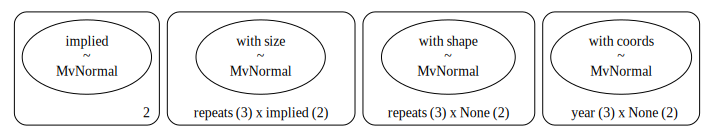

In [14]:
with pm.Model(coords={
    "year": [2020, 2021, 2022],
}) as pmodel:
    # Multivariate RVs (ndim_supp > 0)
    mv = pm.MvNormal("implied", mu=[0, 0], cov=np.eye(2))
    assert mv.ndim == 1
    print(mv.shape.eval())

    mv = pm.MvNormal("with size", mu=[0, 0], cov=np.eye(2), size=3, dims=("repeats", "implied"))
    print(mv.shape.eval())
    
    # ⚠ Size dims are always __prepended__
    mv = pm.MvNormal("with shape", mu=[0, 0], cov=np.eye(2), shape=(3, ...), dims=("repeats", ...))
    print(mv.shape.eval())
    
    mv = pm.MvNormal("with coords", mu=[0, 0], cov=np.eye(2), dims=("year", ...))
    print(mv.shape.eval())



pm.model_to_graphviz(pmodel)

### User caution and practical tips.

While we provide all these tools for convenience, and while PyMC does it best to understand user intent, the result of mixed dimensionality tools may not always result in the final dimensionality intended. Sometimes the model may not indicate an error until sampling, or not indicate an issue at all. When working with dimensionality, particular more complex ones we suggest

* Using GraphViz to visualize your model before sampling
* Using the prior predictive to catch errors early
* Inspecting the returned `az.InferenceData` object to ensure all array sizes are as intended